In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# **Processing Data**

In [2]:
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
holidays_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [3]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [4]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [5]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


## **Merging the target ('sales') with continuous features**

In [9]:
train_wide = train.merge(transactions, on=['date', 'store_nbr'], how='left')
train_wide = train_wide.merge(stores, on='store_nbr', how='left')
train_wide = train_wide.merge(oil, on='date', how='left')

In [10]:
test_wide = test.merge(transactions, on=['date', 'store_nbr'], how='left')
test_wide = test_wide.merge(stores, on='store_nbr', how='left')
test_wide = test_wide.merge(oil, on='date', how='left')

In [11]:
# Making sure the date column is represented as a datetime field
train_wide['date'] = pd.to_datetime(train_wide['date'])
test_wide['date'] = pd.to_datetime(test['date'])

# Renaming the 'dcoilwtico' column which represents dollars per barrell of crude oil
train_wide.rename(columns={'dcoilwtico': 'oil_prices'}, inplace=True)
test_wide.rename(columns={'dcoilwtico': 'oil_prices'}, inplace=True)

In [12]:
## Setting 'date' as the index
train_wide = train_wide.set_index(train_wide['date']).to_period('D')
test_wide = test_wide.set_index(test_wide['date']).to_period('D')

In [13]:
train_wide.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,oil_prices
date,,,,,,,,,,,,
2013-01-01,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,NaN
2013-01-01,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,NaN
2013-01-01,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,NaN
2013-01-01,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,NaN
2013-01-01,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,NaN


In [14]:
test_wide.head()

,id,date,store_nbr,family,onpromotion,transactions,city,state,type,cluster,oil_prices
date,,,,,,,,,,,
2017-08-16,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,Quito,Pichincha,D,13,46.8
2017-08-16,3000889,2017-08-16,1,BABY CARE,0,NaN,Quito,Pichincha,D,13,46.8
2017-08-16,3000890,2017-08-16,1,BEAUTY,2,NaN,Quito,Pichincha,D,13,46.8
2017-08-16,3000891,2017-08-16,1,BEVERAGES,20,NaN,Quito,Pichincha,D,13,46.8
2017-08-16,3000892,2017-08-16,1,BOOKS,0,NaN,Quito,Pichincha,D,13,46.8


In [15]:
import matplotlib.pyplot as plt

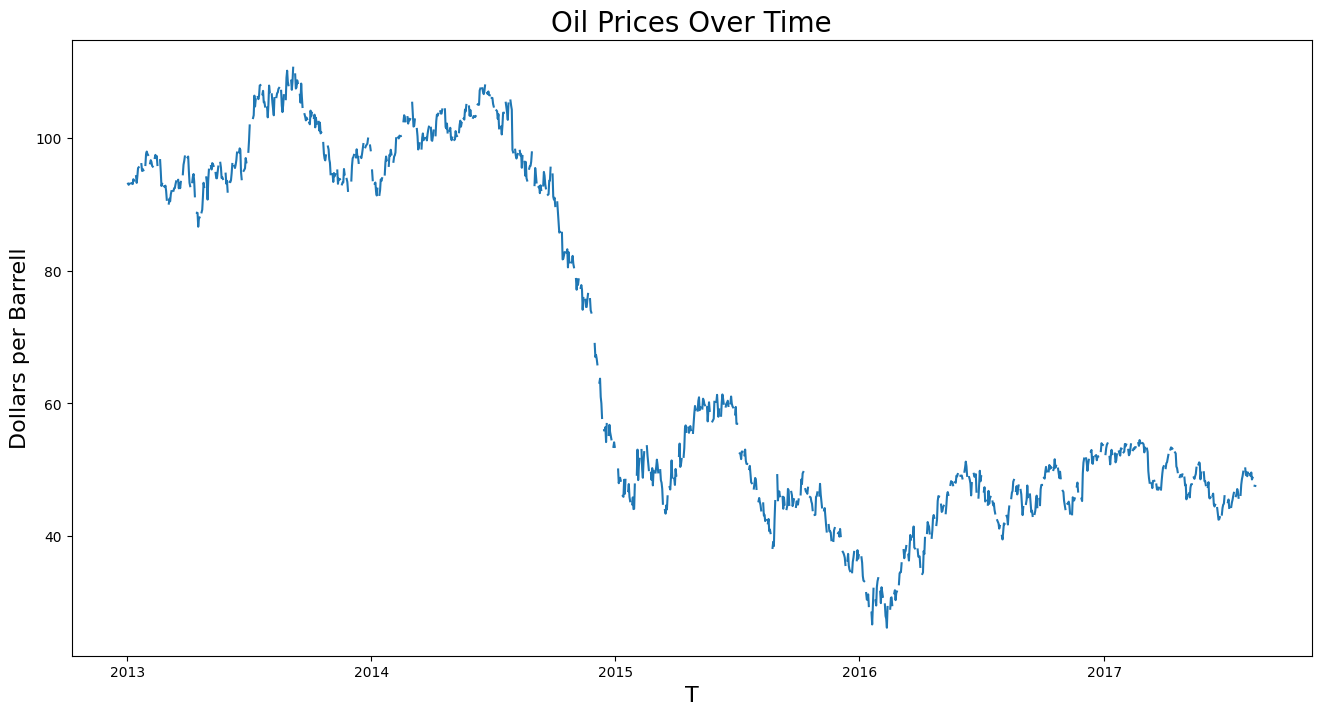

In [16]:
fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(train_wide['date'], train_wide['oil_prices'])
ax0.set_title('Oil Prices Over Time', fontsize=20)
ax0.set_xlabel('T', fontsize=16)
ax0.set_ylabel('Dollars per Barrell', fontsize=16)
plt.show()
plt.close()

### **Comment**
The 'oil_prices' field has many missing values. To address this, a moving average of the oil price over 7 days will be taken to smooth out the data.

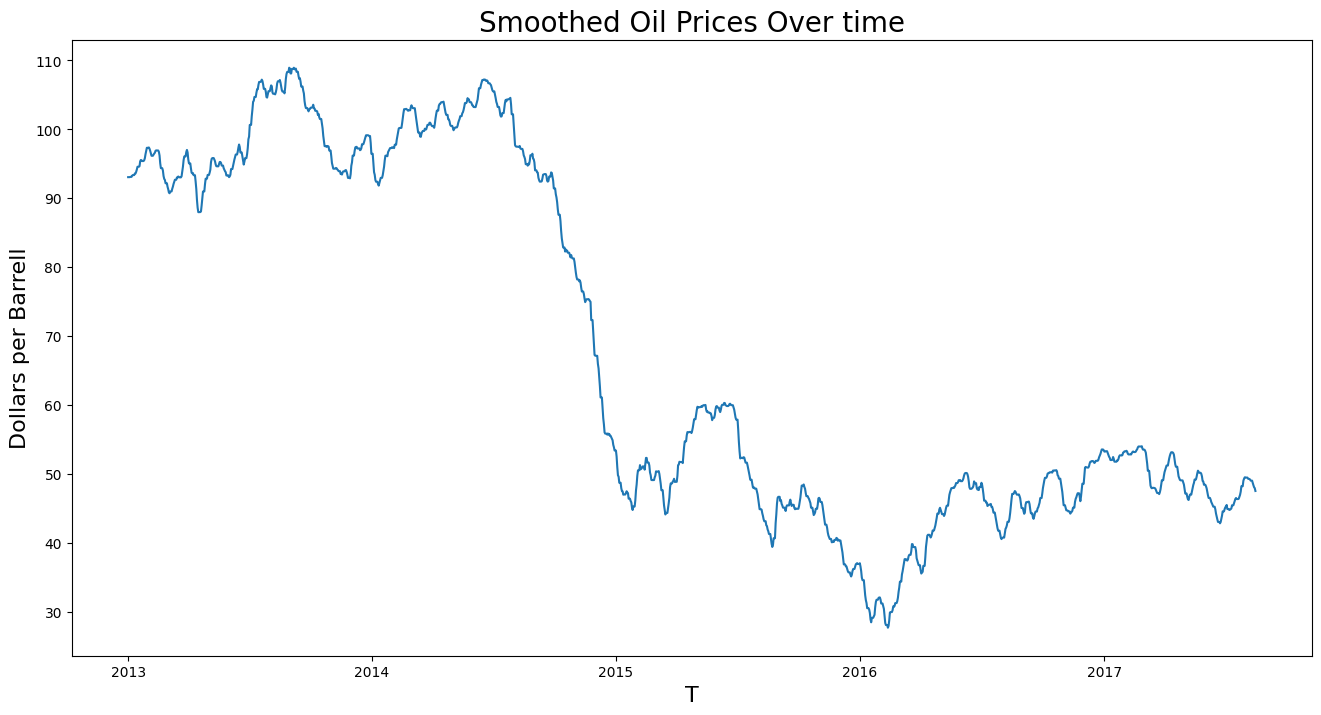

In [17]:
avg_oil_prices_train = train_wide.groupby(train_wide['date']).agg({'oil_prices': 'mean'})
avg_oil_prices_train = avg_oil_prices_train.rolling(window=7,
                                                    min_periods=1,
                                                    center=True).mean()

fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(avg_oil_prices_train)
ax0.set_title('Smoothed Oil Prices Over time', fontsize=20)
ax0.set_xlabel('T', fontsize=16)
ax0.set_ylabel('Dollars per Barrell', fontsize=16)
plt.show()
plt.close()

In [18]:
# Applying the same transformation to test data oil prices
avg_oil_prices_test = test_wide.groupby(test_wide['date']).agg({'oil_prices': 'mean'})
avg_oil_prices_test = avg_oil_prices_test.rolling(window=7,
                                                  min_periods=1,
                                                  center=True).mean()

# **EDA**

## **Plotting daily average sales against some of the continuous features**

In [19]:
daily_avg_sales = train_wide.groupby(train_wide['date']).agg({'sales': 'mean'})
daily_ttl_transactions = train_wide.groupby(train_wide['date']).agg({'transactions': 'sum'})
daily_ttl_promotions = train_wide.groupby(train_wide['date']).agg({'onpromotion': 'sum'})

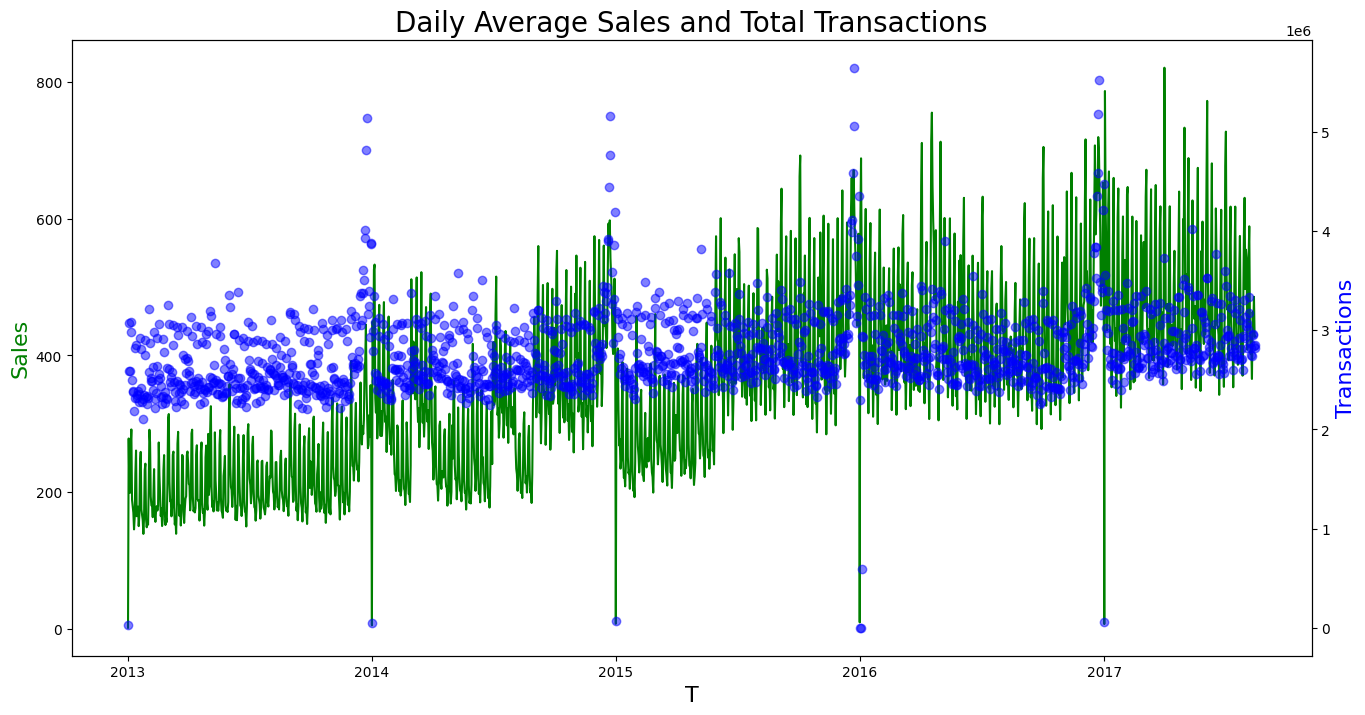

In [20]:
fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(daily_avg_sales, 'g-')
ax1 = ax0.twinx()
ax1.plot(daily_ttl_transactions, 'bo', alpha=0.50)

ax0.set_title('Daily Average Sales and Total Transactions', fontsize=20)
ax0.set_xlabel('T', fontsize=16)
ax0.set_ylabel('Sales', fontsize=16, color='g')
ax1.set_ylabel('Transactions', fontsize=16, color='b')
plt.show()
plt.close()

### **Comment**
At a glance, it appears that there may be some sort of lag relationship between transactions and sales.

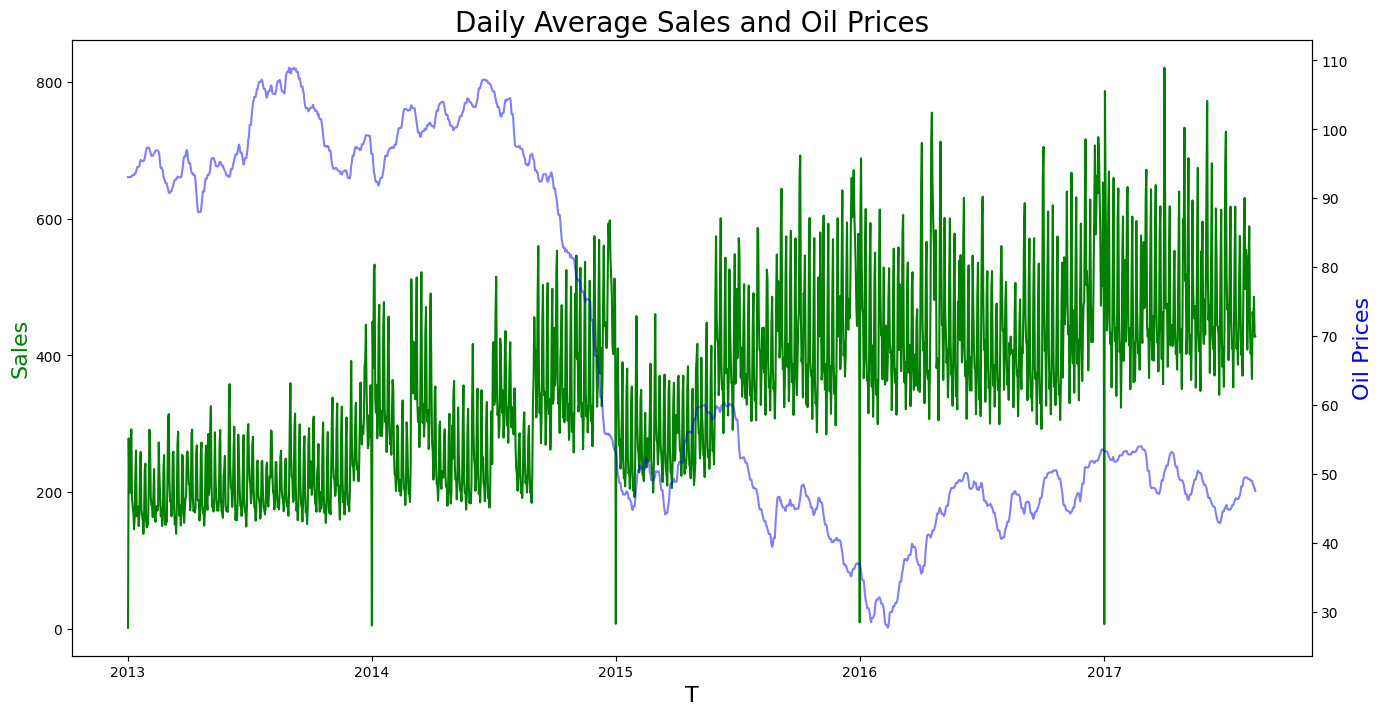

In [21]:
fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(daily_avg_sales, 'g-')
ax1 = ax0.twinx()
ax1.plot(avg_oil_prices_train, 'b-', alpha=0.50)

ax0.set_title('Daily Average Sales and Oil Prices', fontsize=20)
ax0.set_xlabel('T', fontsize=16)
ax0.set_ylabel('Sales', fontsize=16, color='g')
ax1.set_ylabel('Oil Prices', fontsize=16, color='b')
plt.show()
plt.close()

### **Comment**
At a glance, it appears that there may be could be sort of inverse trend relationship between oil prices and sales. As oil prices trend down, it appears that sales trend up.

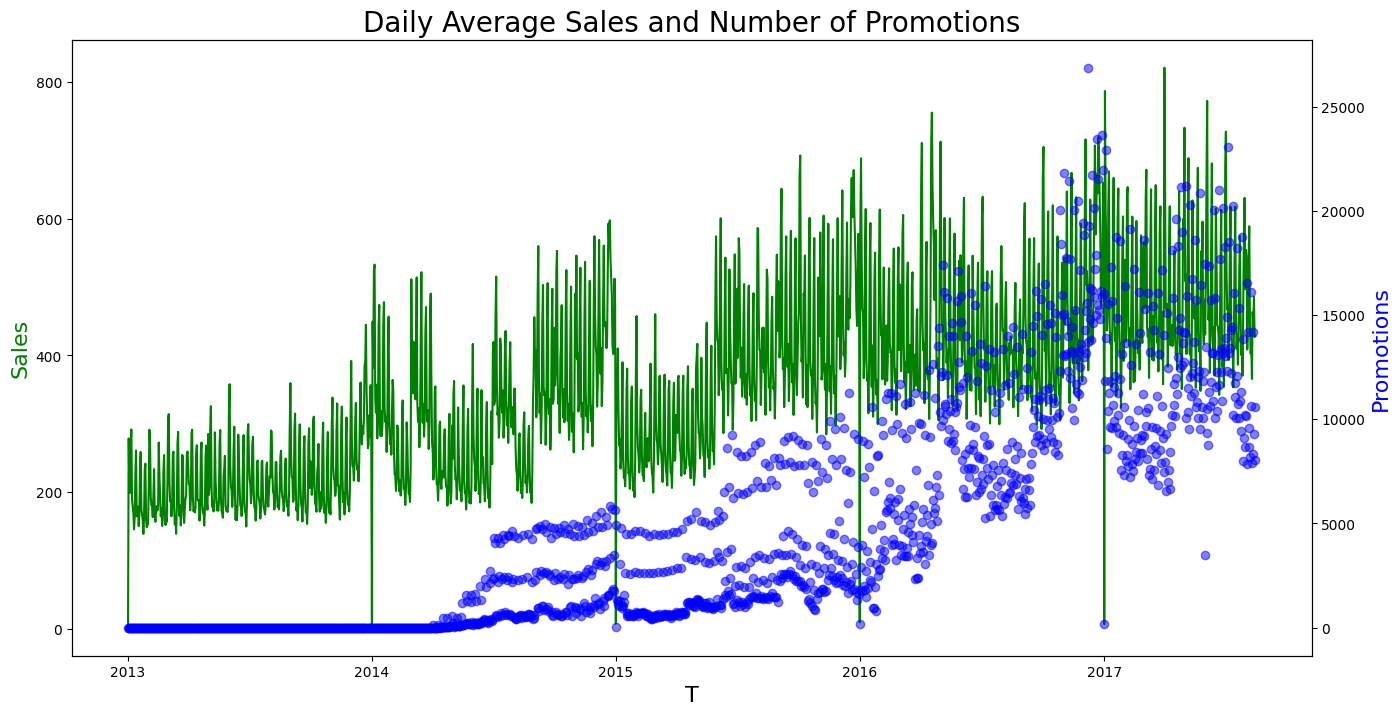

In [22]:
fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(daily_avg_sales, 'g-')
ax1 = ax0.twinx()
ax1.plot(daily_ttl_promotions, 'bo', alpha=0.50)

ax0.set_title('Daily Average Sales and Number of Promotions', fontsize=20)
ax0.set_xlabel('T', fontsize=16)
ax0.set_ylabel('Sales', fontsize=16, color='g')
ax1.set_ylabel('Promotions', fontsize=16, color='b')
plt.show()
plt.close()

### **Comment**
In general, it appears that as the number of promotions on any given day trended up over time, so did sales.

## **Creating a correlation matrix of the relationship between sales and the continuous features**

In [23]:
daily_aggs = pd.concat([daily_avg_sales, 
                        daily_ttl_transactions, 
                        avg_oil_prices_train, 
                        daily_ttl_promotions], axis=1)
print(daily_aggs.corr())

                 sales  transactions  oil_prices  onpromotion
sales         1.000000      0.656308   -0.628398     0.574943
transactions  0.656308      1.000000   -0.229166     0.200228
oil_prices   -0.628398     -0.229166    1.000000    -0.621415
onpromotion   0.574943      0.200228   -0.621415     1.000000


### **Comment**
It appears that there is a strong positive correlation between transactions and promotions with sales and a strong negative correlation betweeen oil prices and sales. This corroborates the observations made thus far based on the visualizations.

It seems like a reasonable theory that as oil prices fell, goods became more affordable allowing for more promotions resulting in a greater number of transactions and sales.

## **Plotting categorical feature relationships with sales**

In [24]:
family_sales = train_wide.groupby('family').agg({'sales': 'mean'})
family_sales.sort_values(by='sales', ascending=False, inplace=True)

# Making sure clusters are interpreted as categories and not continuous values
train_wide = train_wide.astype({'cluster': 'str'})
cluster_sales = train_wide.groupby('cluster').agg({'sales': 'mean'})
cluster_sales.sort_values(by='sales', ascending=False, inplace=True)

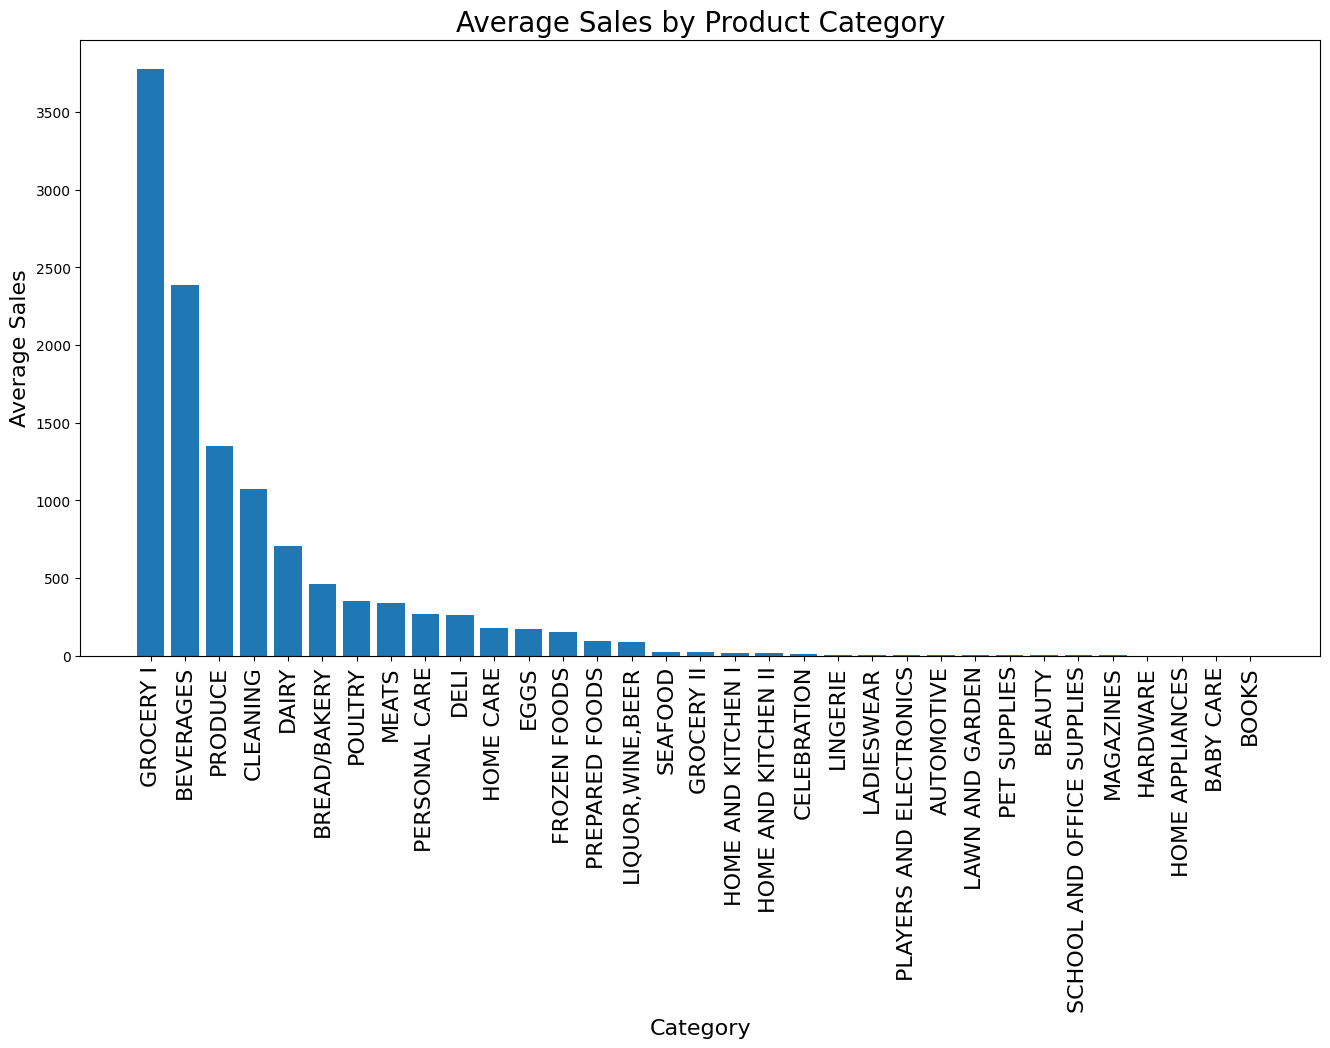

In [25]:
fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.bar(x=family_sales.index, height=family_sales['sales'])
ax0.set_title('Average Sales by Product Category', fontsize=20)
ax0.set_xlabel('Category', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
ax0.set_ylabel('Average Sales', fontsize=16)
plt.show()
plt.close()

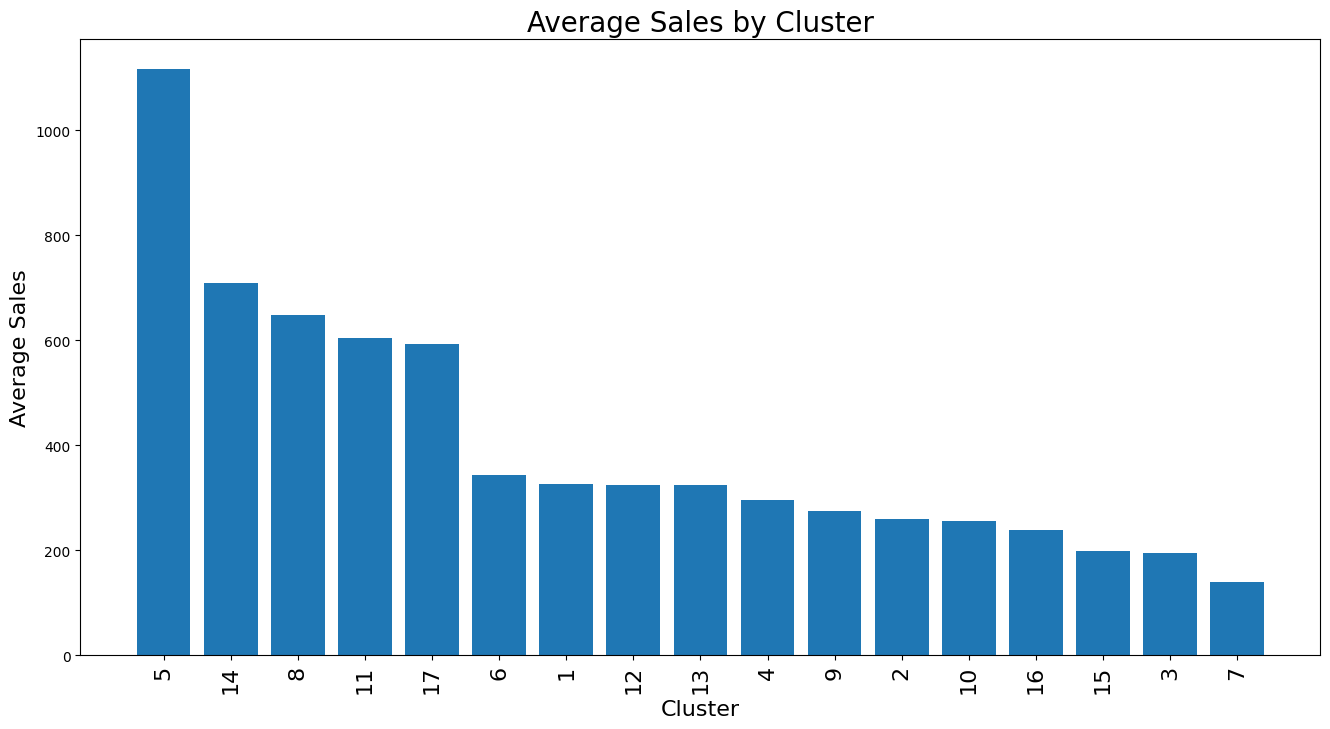

In [26]:
fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.bar(x=cluster_sales.index, height=cluster_sales['sales'])
ax0.set_title('Average Sales by Cluster', fontsize=20)
ax0.set_xlabel('Cluster', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
ax0.set_ylabel('Average Sales', fontsize=16)
plt.show()
plt.close()

### **Comment**
The above plots show that certain product categories and store clusters contributed significantly more to average sales than others.

# **Decomposing the Time Series**

## **Trend**

In [27]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

In [28]:
training = daily_avg_sales.loc[daily_avg_sales.index.year < 2017,:]
training.index = training.index.to_period('D')
validation = daily_avg_sales.loc[daily_avg_sales.index.year >= 2017,:]
validation.index = validation.index.to_period('D')

In [29]:
dp_trend = DeterministicProcess(index=training.index,
                                constant=True, # create dummy feature for y intercept,
                                order=1, # modelling a linear trend,
                                drop=True)

Xtrain = dp_trend.in_sample()
Xvalid = dp_trend.out_of_sample(steps=227)

In [30]:
# Discovering the trend in the sales data using simple linear regression
trend_model = LinearRegression(fit_intercept=False)
ytrain = training['sales']
ytrain.index = ytrain.index.to_timestamp()
yvalid = validation['sales']
yvalid.index = yvalid.index.to_timestamp()

trend_model.fit(Xtrain, ytrain)
trend_pred = pd.Series(trend_model.predict(Xtrain), index=Xtrain.index.to_timestamp())
trend_forecast = pd.Series(trend_model.predict(Xvalid), index=Xvalid.index.to_timestamp())

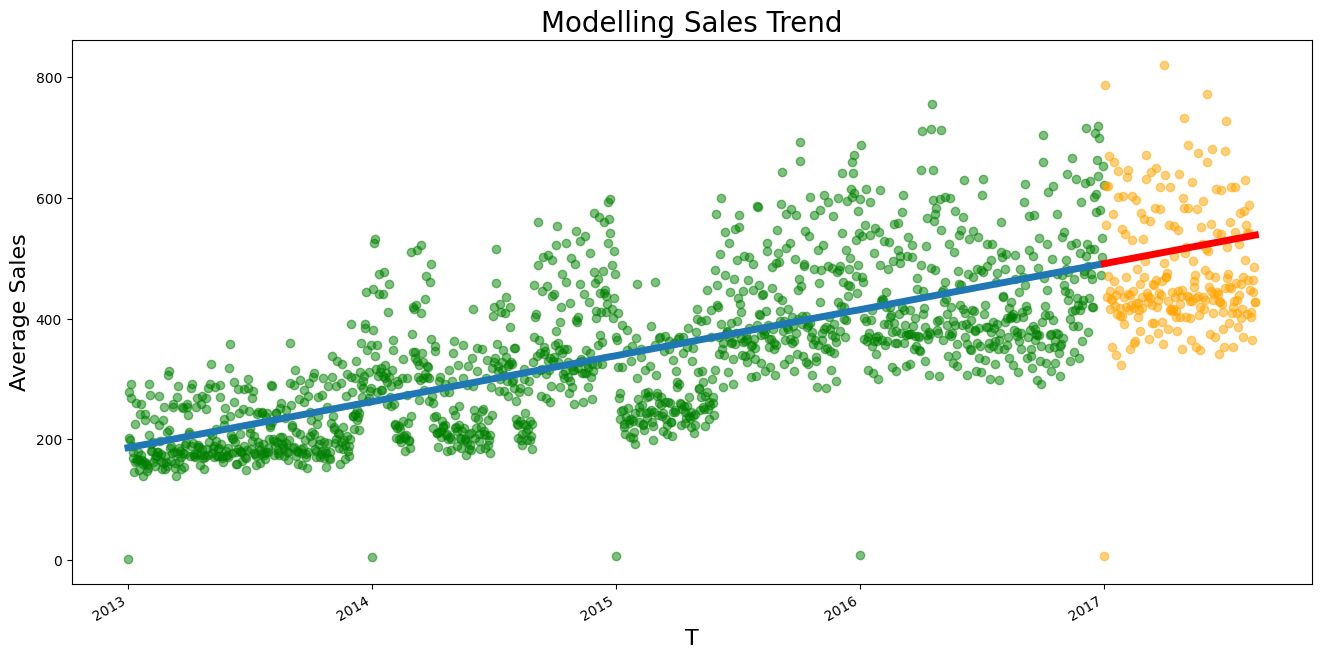

In [31]:
fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(ytrain, 'go', alpha=0.50)
trend_pred.plot(ax=ax0, linewidth=5)
yvalid.plot(ax=ax0, color='orange', marker='o', linestyle='', alpha=0.50)
trend_forecast.plot(ax=ax0, linewidth=5, color='r')
ax0.set_title('Modelling Sales Trend', fontsize=20)
ax0.set_xlabel('T', fontsize=16)
ax0.set_ylabel('Average Sales', fontsize=16)
plt.show()
plt.close()

### **Comment**
The trend line in blue appears to capture the upward trend in sales over time. The forecast line in red seems to continue to accurately capture the trend in the validation data (orange points) that was not fed to the model.

### **Detrending the data**

Removing the trend from the data by subtracting it. It seems safe to assume an additive model since the trend looks more or less linear.

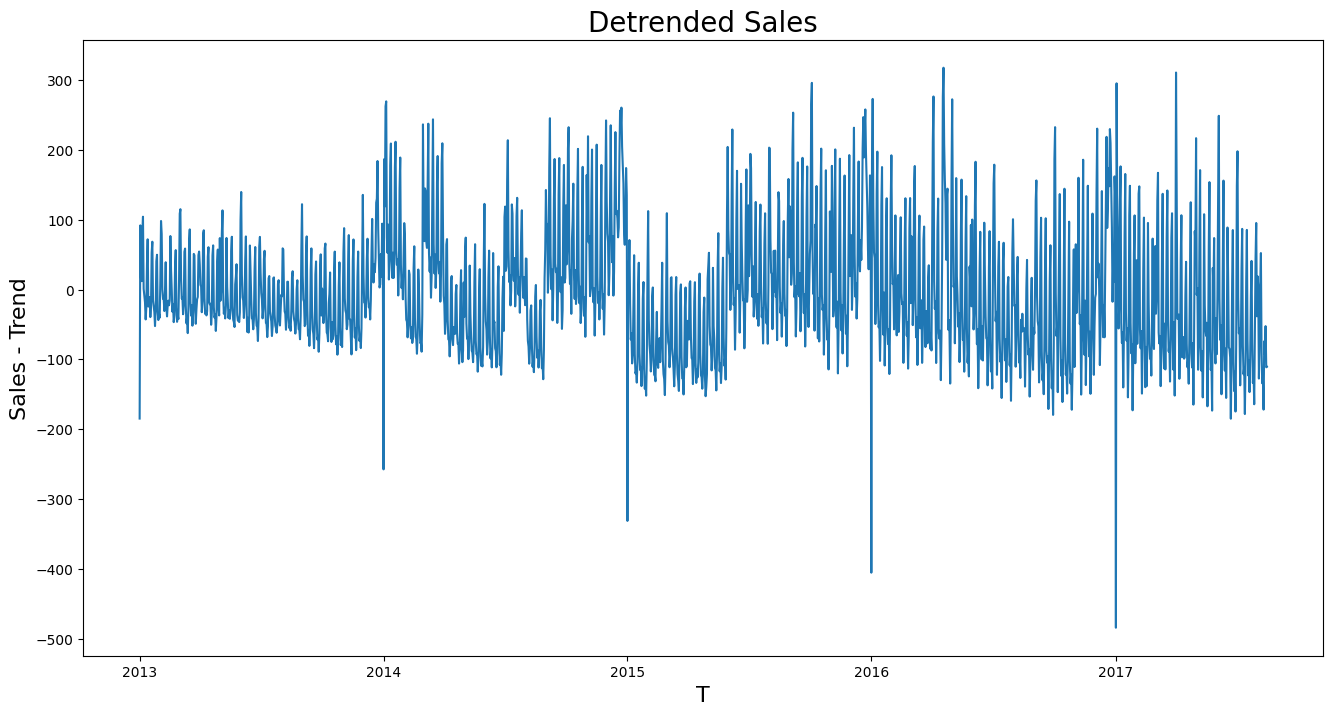

In [32]:
sales_detrend = pd.concat([(ytrain - trend_pred), (yvalid - trend_forecast)], axis=0)

fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(sales_detrend)
ax0.set_title('Detrended Sales', fontsize=20)
ax0.set_xlabel('T', fontsize=16)
ax0.set_ylabel('Sales - Trend', fontsize=16)
plt.show()
plt.close()

### **Comment**
Looks like the upward trend has been appropriately removed.

## **Seasonality**

### **Plotting data by different periods**
By visually inspecting the data grouped by various periods it may be possible to ascertain any seasonality in the data if present.

In [33]:
import seaborn as sns

In [34]:
X = daily_avg_sales.copy()
X['day'] = X.index.dayofweek
X['week'] = X.index.isocalendar().week
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

In [35]:
day_week_group = X.groupby(['day', 'week']).agg({'sales': 'mean'}).unstack()
day_week_group.set_index(pd.Index(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']), inplace=True)

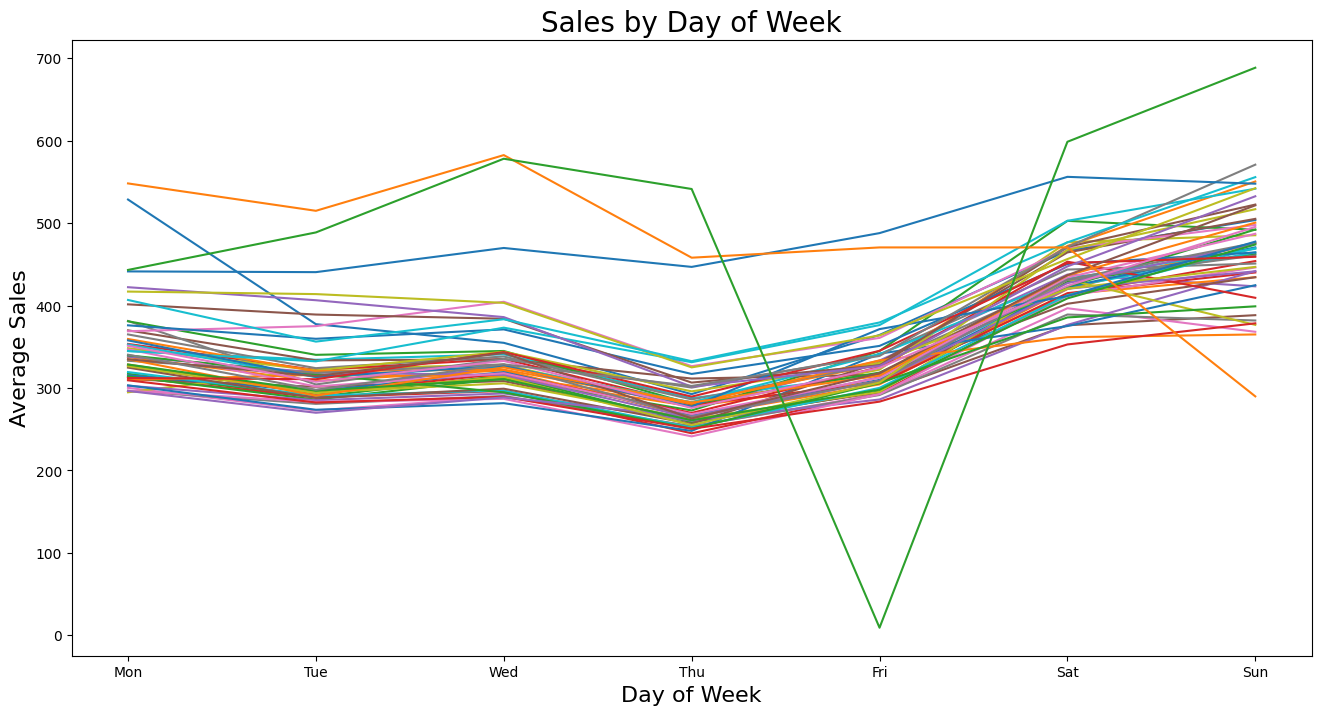

In [36]:
fig, ax0 = plt.subplots(figsize=(16, 8))
day_week_group.plot(ax=ax0, legend=False)
ax0.set_title('Sales by Day of Week', fontsize=20)
ax0.set_xlabel('Day of Week', fontsize=16)
ax0.set_ylabel('Average Sales', fontsize=16)
plt.show()
plt.close()

### **Comment**
There does seem to be a pattern where sales are generally higher on the weekends than during the weekday, but there is still some variability.

In [37]:
day_year_group = X.groupby(['dayofyear', 'year']).agg({'sales': 'mean'}).unstack()

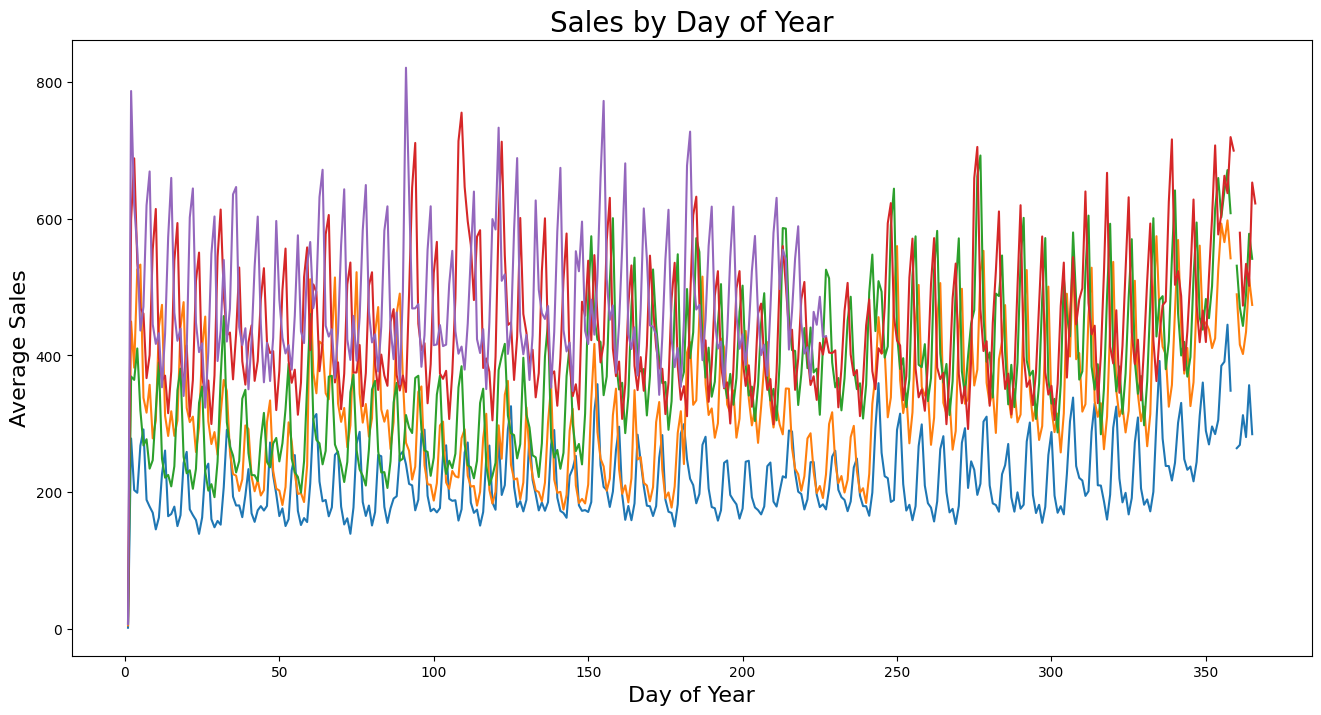

In [38]:
fig, ax0 = plt.subplots(figsize=(16, 8))
day_year_group.plot(ax=ax0, legend=False)
ax0.set_title('Sales by Day of Year', fontsize=20)
ax0.set_xlabel('Day of Year', fontsize=16)
ax0.set_ylabel('Average Sales', fontsize=16)
plt.show()
plt.close()

### **Comment**
Similarly to the 'Day of Week' plot, it is hard to tell if there is an observable seasonality. Will need to conduct further investigation by plotting periodograms.

In [39]:
from scipy.signal import periodogram

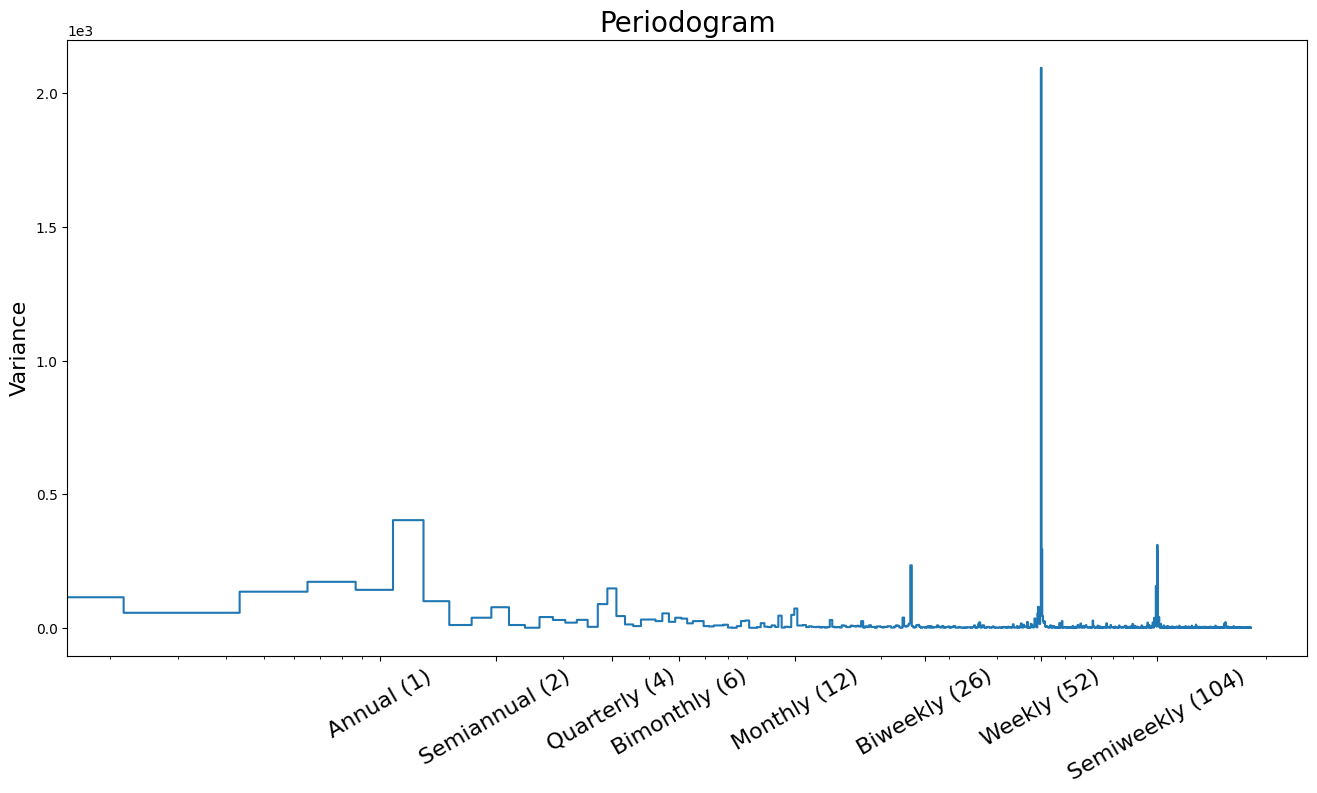

In [40]:
frequencies, spectrum = periodogram(x=daily_avg_sales['sales'],
                                  fs=pd.Timedelta('365D') / pd.Timedelta('1D'),
                                  window='boxcar',
                                  detrend='linear',
                                  scaling='spectrum')

fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.step(frequencies, spectrum)
ax0.set_title('Periodogram', fontsize=20)
ax0.set_xscale('log')
ax0.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax0.set_xticklabels(['Annual (1)',
                     'Semiannual (2)',
                     'Quarterly (4)',
                     'Bimonthly (6)',
                     'Monthly (12)',
                     'Biweekly (26)',
                     'Weekly (52)',
                     'Semiweekly (104)'], rotation=30)
plt.xticks(fontsize=16)
ax0.set_ylabel('Variance', fontsize=16)
ax0.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.show()
plt.close()

### **Comment**
Looks like there is both a weekly season as well as annual. Will need to model both but using different techniques for each type of season.

The annual season can be modelled using Fourier features since they are more appropriate for modelling seasons with many observations. Since the periodogram seems to flatten out somewhere between quarterly and monthly, around 6-8 Fourier pairs seems appropriate.

The weekly season will be modelled using indicators, which are appropriate for modelling seasons with fewer observations since creating indicator features involves using one-hot encoding to create a new binary dummy feature for each observation in a seasonal period (i.e. for a seasonal period of a week, this would involve creating a new binary dummy feature for each day of the week).

In [41]:
from statsmodels.tsa.deterministic import CalendarFourier

In [42]:
fourier = CalendarFourier(freq='YE', order=6) # Year frequency seasonality modelled by 6 sin/cos pairs

In [43]:
training = daily_avg_sales.loc[daily_avg_sales.index.year < 2017,:]
training.index = training.index.to_period('D')
validation = daily_avg_sales.loc[daily_avg_sales.index.year >= 2017,:]
validation.index = validation.index.to_period('D')

In [44]:
dp_season = DeterministicProcess(index=training.index,
                                 constant=True,
                                 order=1,
                                 seasonal=True,
                                 additional_terms=[fourier],
                                 drop=True)

Xtrain = dp_season.in_sample()
Xvalid = dp_season.out_of_sample(steps=227)

In [45]:
# Modelling seasonality based on the data with the trend removed so that the seasonality is more obvious
season_model = LinearRegression(fit_intercept=False)

ytrain = ytrain - trend_pred
yvalid = yvalid - trend_forecast

season_model.fit(Xtrain, ytrain)
season_pred = pd.Series(season_model.predict(Xtrain), index=Xtrain.index.to_timestamp())
season_forecast = pd.Series(season_model.predict(Xvalid), index=Xvalid.index.to_timestamp())

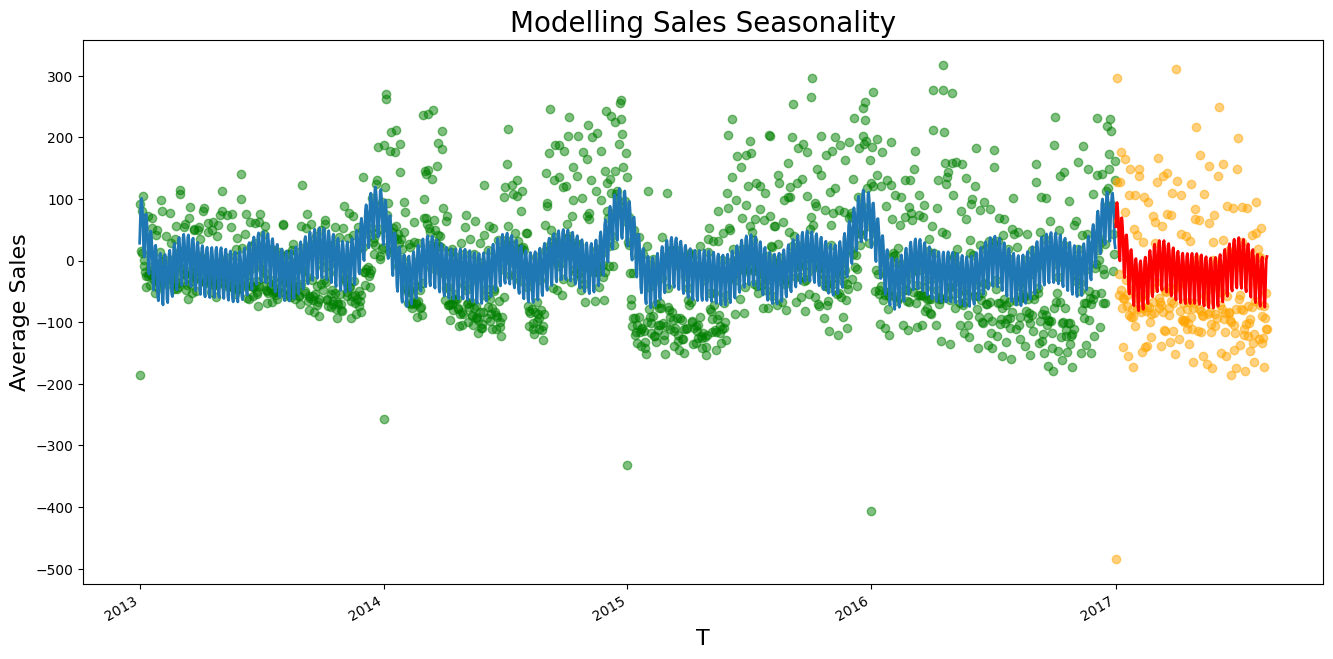

In [46]:
fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(ytrain, 'go', alpha=0.50)
season_pred.plot(ax=ax0, linewidth=2)
yvalid.plot(ax=ax0, color='orange', marker='o', linestyle='', alpha=0.50)
season_forecast.plot(ax=ax0, linewidth=2, color='r')
ax0.set_title('Modelling Sales Seasonality', fontsize=20)
ax0.set_xlabel('T', fontsize=16)
ax0.set_ylabel('Average Sales', fontsize=16)
plt.show()
plt.close()

### **Comment**
Harder to tell solely based on visual inspection if the seasonality has been accurately modelled, but at the very least it does not look completely off-base. At a glance, it appears that the annual and weekly seasonalities have been captured.

### **Plotting the data with the trend and seasonal components removed**

In [47]:
sales_deseason = pd.concat([(ytrain - season_pred), (yvalid - season_forecast)], axis=0)

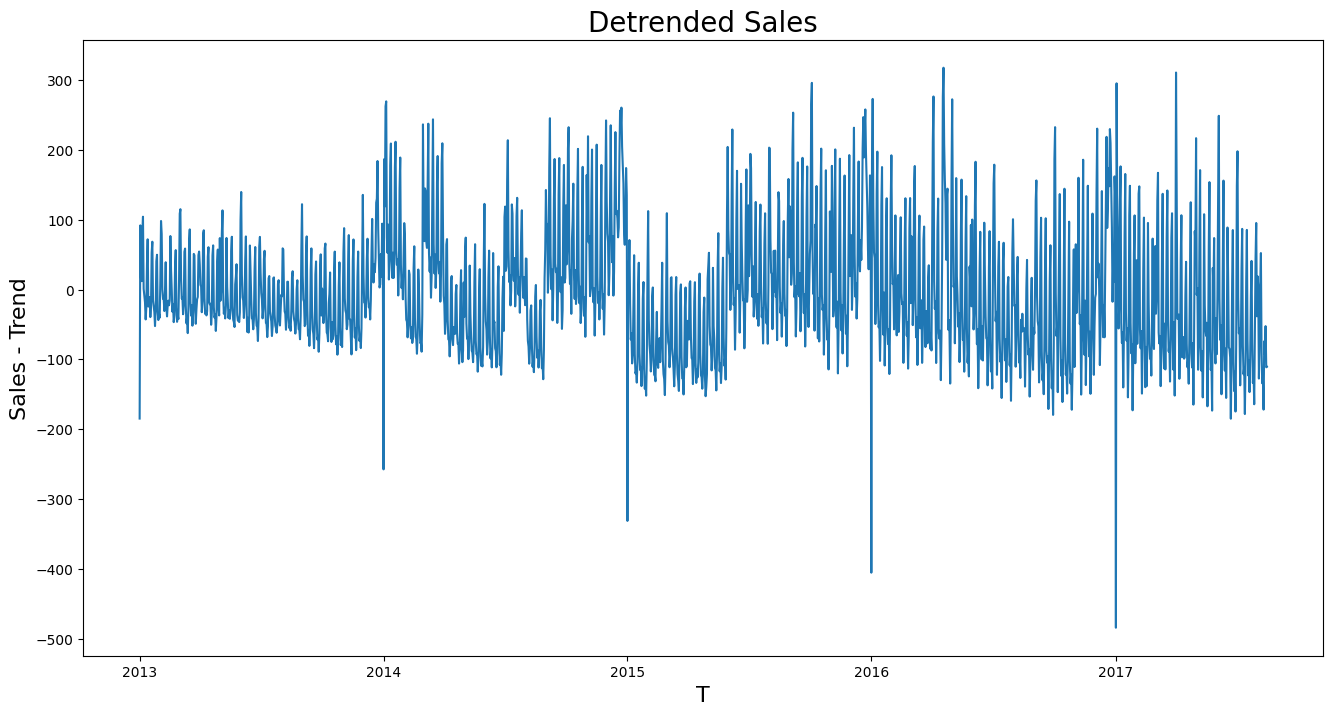

In [48]:
fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(sales_detrend)
ax0.set_title('Detrended Sales', fontsize=20)
ax0.set_xlabel('T', fontsize=16)
ax0.set_ylabel('Sales - Trend', fontsize=16)
plt.show()
plt.close()

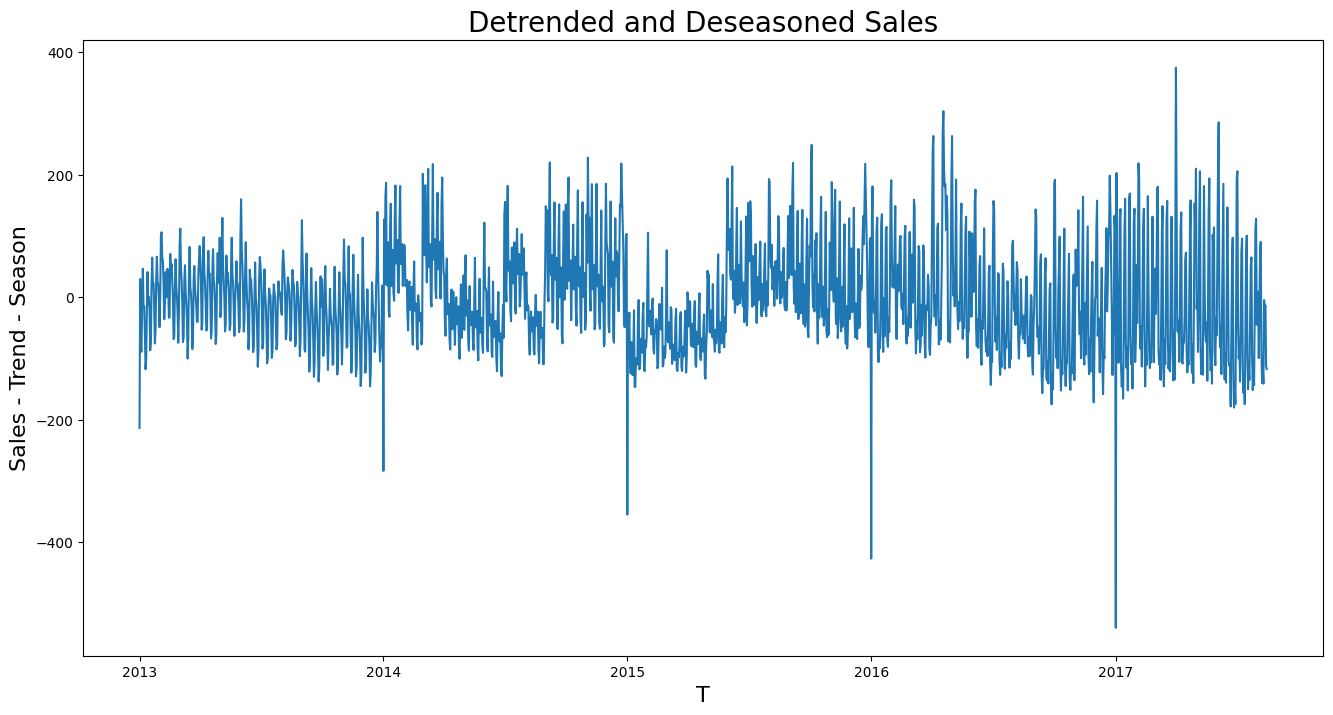

In [49]:
fig, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(sales_deseason)
ax0.set_title('Detrended and Deseasoned Sales', fontsize=20)
ax0.set_xlabel('T', fontsize=16)
ax0.set_ylabel('Sales - Trend - Season', fontsize=16)
plt.show()
plt.close()

### **Comment**
Between the plot of the detrended sales data and the sales data with both trend and seasonality removed, there is a subtle difference. What remains should represent cyclical data (if any) and residuals which a model will try to learn and predict/forecast. Then, by adding back the seasonality and trend that have been modelled based on the training data, the final predictions/forecasts can be made.

### **Retraining the trend and seasonality models on the entire training dataset**

## **Cyclicity/Serial Dependence**

### **Creating lag variables**
By shifting the sales data by various periods, it is possible to determine whether a target's past values can act as features for current and future values.

In [50]:
X = pd.concat({f"sales_lag_{i}": daily_avg_sales.shift(i) for i in range(1, 9)}, axis=1)
X['sales'] = daily_avg_sales['sales']
X.fillna(0.0, inplace=True)

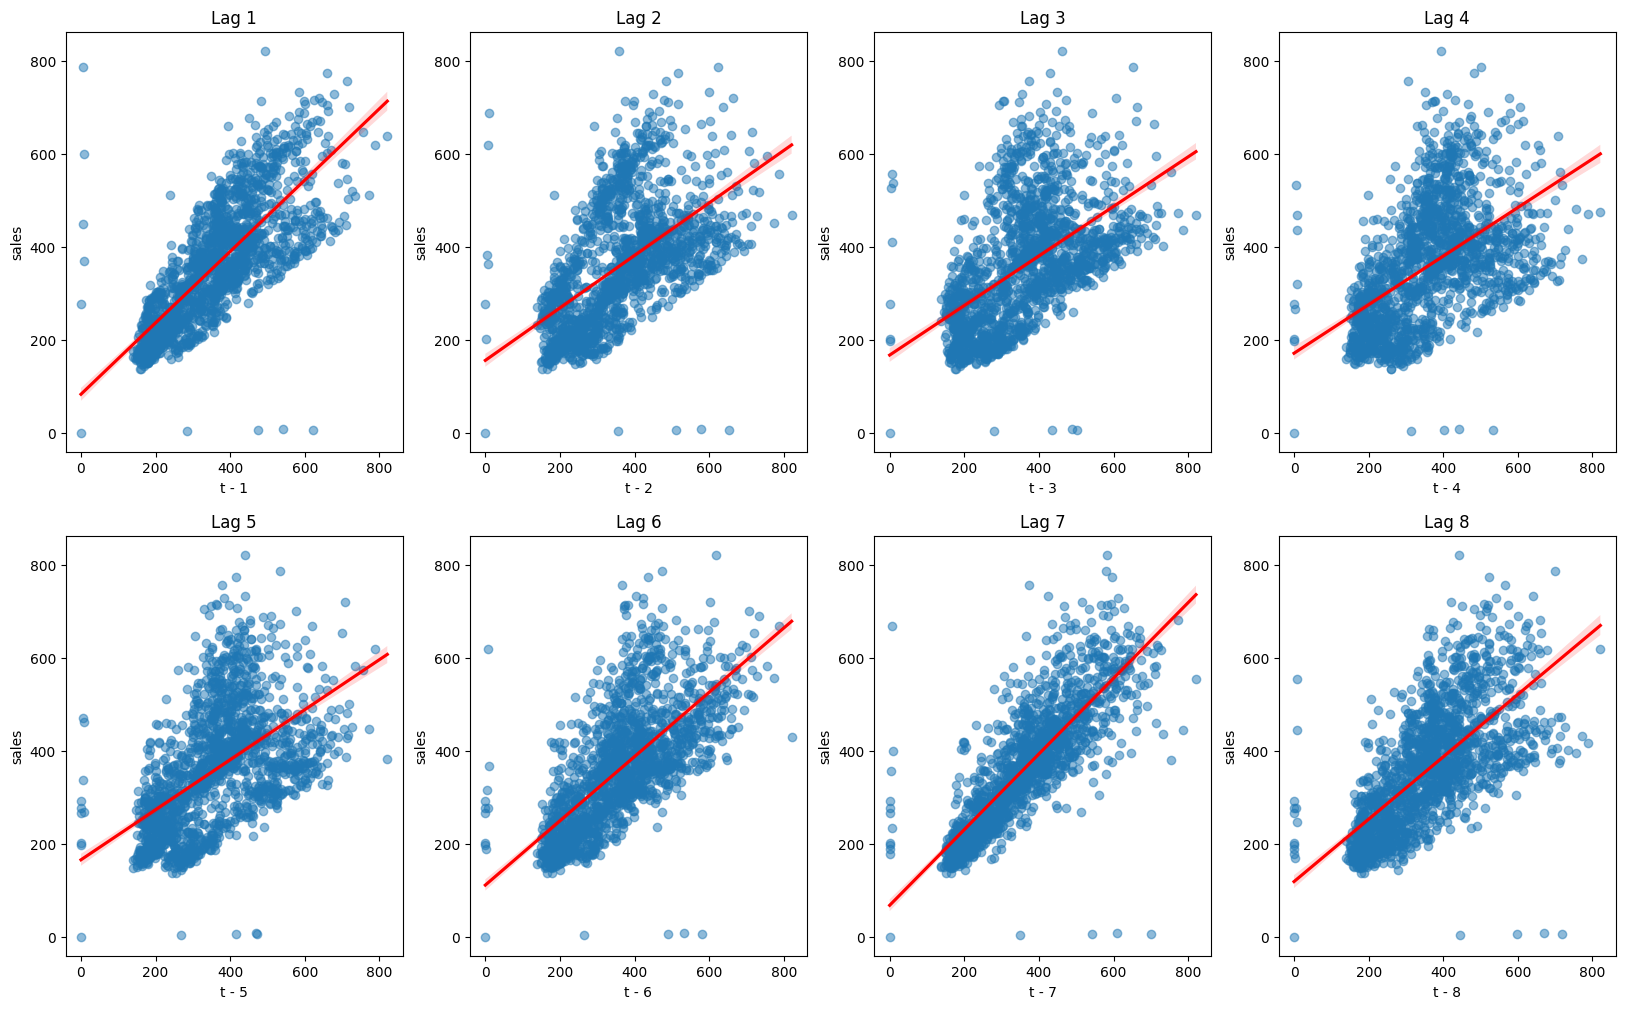

In [51]:
fig, ax0 = plt.subplots(nrows=2, ncols=4, figsize=(20, 12))
ax0[0][0].set_title('Lag 1')
curr_ax = sns.regplot(ax=ax0[0][0], data=X, x='sales_lag_1', y='sales', scatter_kws={'alpha': 0.50}, line_kws={'color': 'r'})
curr_ax.set(xlabel='t - 1')

ax0[0][1].set_title('Lag 2')
curr_ax = sns.regplot(ax=ax0[0][1], data=X, x='sales_lag_2', y='sales', scatter_kws={'alpha': 0.50}, line_kws={'color': 'r'})
curr_ax.set(xlabel='t - 2')

ax0[0][2].set_title('Lag 3')
curr_ax = sns.regplot(ax=ax0[0][2], data=X, x='sales_lag_3', y='sales', scatter_kws={'alpha': 0.50}, line_kws={'color': 'r'})
curr_ax.set(xlabel='t - 3')

ax0[0][3].set_title('Lag 4')
curr_ax = sns.regplot(ax=ax0[0][3], data=X, x='sales_lag_4', y='sales', scatter_kws={'alpha': 0.50}, line_kws={'color': 'r'})
curr_ax.set(xlabel='t - 4')

ax0[1][0].set_title('Lag 5')
curr_ax = sns.regplot(ax=ax0[1][0], data=X, x='sales_lag_5', y='sales', scatter_kws={'alpha': 0.50}, line_kws={'color': 'r'})
curr_ax.set(xlabel='t - 5')

ax0[1][1].set_title('Lag 6')
curr_ax = sns.regplot(ax=ax0[1][1], data=X, x='sales_lag_6', y='sales', scatter_kws={'alpha': 0.50}, line_kws={'color': 'r'})
curr_ax.set(xlabel='t - 6')

ax0[1][2].set_title('Lag 7')
curr_ax = sns.regplot(ax=ax0[1][2], data=X, x='sales_lag_7', y='sales', scatter_kws={'alpha': 0.50}, line_kws={'color': 'r'})
curr_ax.set(xlabel='t - 7')

ax0[1][3].set_title('Lag 8')
curr_ax = sns.regplot(ax=ax0[1][3], data=X, x='sales_lag_8', y='sales', scatter_kws={'alpha': 0.50}, line_kws={'color': 'r'})
curr_ax.set(xlabel='t - 8')
plt.show()
plt.close()

### **Comment**
Sales may have strong serial dependence with the lag 1 and lag 7 features. Applying domain knowledge, this makes sense because sales of grocery type items comprise a large percentage of the sales data and groceries are typically purchased weekly (lag 7) and the amount of groceries bought the day before (lag 1) could definitely impact the amount of groceries purchased a day later. It also appears that the relationship between sales and lagged sales is linear for the most part meaning that a measure of linear correlation like autocorrelation can be applied for further analysis (otherwise, more general measures of dependence can be used such as mutual information). 

### **Plotting a correlogram to further investigate which lag features may prove useful**

In [52]:
from statsmodels.graphics.tsaplots import plot_pacf

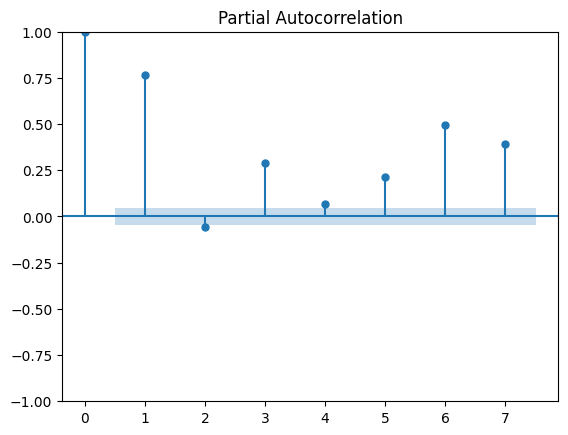

In [53]:
_ = plot_pacf(daily_avg_sales['sales'], lags=7)

### **Comment**
Based on the partial autocorrelation (correlogram) plot, it appears that lags 1, 3, 5, 6, 7 might provide additional correlation information after taking into consideration all previous lags.

# **Making Forecast**
Will be keeping this a strictly forecasting problem as opposed to turning it into a prediction + forecasting problem.

## **Preparing the data for forecasting**

In [54]:
Xtrain = train_wide[['family', 'store_nbr', 'sales']]
Xtrain = Xtrain.set_index(['family', 'store_nbr'], append=True, drop=True).sort_index()
Xtrain = Xtrain.join(avg_oil_prices_train)
Xtrain = Xtrain.fillna(0.0)

In [55]:
ytrain = Xtrain.unstack(['family', 'store_nbr']).loc[:, 'sales']

In [56]:
# Same as previous dp_season except on the entire training dataset (not splitting into train-validation)
# This includes the trend term
dp_season = DeterministicProcess(index=Xtrain.index.get_level_values('date').unique(),
                                 constant=True,
                                 order=1,
                                 seasonal=True,
                                 additional_terms=[fourier],
                                 drop=True)
Xtrain_season = dp_season.in_sample()

In [57]:
Xtrain_season

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)","sin(5,freq=YE-DEC)","cos(5,freq=YE-DEC)","sin(6,freq=YE-DEC)","cos(6,freq=YE-DEC)"
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,0.085965,0.996298,0.103102,0.994671
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,0.171293,0.985220,0.205104,0.978740
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,0.255353,0.966848,0.304921,0.952378
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,0.337523,0.941317,0.401488,0.915864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,1680.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.628763,-0.777597,0.977848,0.209315,-0.891981,0.452072,0.409356,-0.912375,0.255353,0.966848,-0.806480,-0.591261
2017-08-12,1.0,1681.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.642055,-0.766659,0.984474,0.175531,-0.867456,0.497513,0.345612,-0.938377,0.337523,0.941317,-0.863142,-0.504961
2017-08-13,1.0,1682.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.655156,-0.755493,0.989932,0.141540,-0.840618,0.541628,0.280231,-0.959933,0.417194,0.908818,-0.910605,-0.413279


In [58]:
Xtest_season = dp_season.out_of_sample(steps=16)
Xtest_season.index.name = 'date'

In [59]:
Xtest_season

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)","sin(5,freq=YE-DEC)","cos(5,freq=YE-DEC)","sin(6,freq=YE-DEC)","cos(6,freq=YE-DEC)"
date,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,1685.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.693281,-0.720667,0.999250,0.038722,-0.746972,0.664855,0.077386,-0.997001,0.635432,0.772157,-0.993257,-0.115935
2017-08-17,1.0,1686.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.705584,-0.708627,0.999991,0.004304,-0.711657,0.702527,0.008607,-0.999963,0.699458,0.714673,-0.999917,-0.012910
2017-08-18,1.0,1687.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.717677,-0.696376,0.999546,-0.030120,-0.674444,0.738326,-0.060213,-0.998186,0.758306,0.651899,-0.995919,0.090252
2017-08-19,1.0,1688.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.729558,-0.683919,0.997917,-0.064508,-0.635432,0.772157,-0.128748,-0.991677,0.811539,0.584298,-0.981306,0.192452
2017-08-20,1.0,1689.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.741222,-0.671260,0.995105,-0.098820,-0.594727,0.803928,-0.196673,-0.980469,0.858764,0.512371,-0.956235,0.292600
2017-08-21,1.0,1690.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.752667,-0.658402,0.991114,-0.133015,-0.552435,0.833556,-0.263665,-0.964614,0.899631,0.436651,-0.920971,0.389630
2017-08-22,1.0,1691.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.763889,-0.645348,0.985948,-0.167052,-0.508671,0.860961,-0.329408,-0.944188,0.933837,0.357698,-0.875892,0.482508
2017-08-23,1.0,1692.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.774884,-0.632103,0.979614,-0.200891,-0.463550,0.886071,-0.393590,-0.919286,0.961130,0.276097,-0.821477,0.570242
2017-08-24,1.0,1693.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.785650,-0.618671,0.972118,-0.234491,-0.417194,0.908818,-0.455907,-0.890028,0.981306,0.192452,-0.758306,0.651899


In [60]:
Xall_season = pd.concat([Xtrain_season, Xtest_season], axis=0)

In [61]:
Xall_season

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)","sin(5,freq=YE-DEC)","cos(5,freq=YE-DEC)","sin(6,freq=YE-DEC)","cos(6,freq=YE-DEC)"
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,0.085965,0.996298,0.103102,0.994671
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,0.171293,0.985220,0.205104,0.978740
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,0.255353,0.966848,0.304921,0.952378
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,0.337523,0.941317,0.401488,0.915864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,1.0,1696.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.816538,-0.577292,0.942761,-0.333469,-0.271958,0.962309,-0.628763,-0.777597,0.997917,-0.064508,-0.523416,0.852078
2017-08-28,1.0,1697.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.826354,-0.563151,0.930724,-0.365723,-0.221922,0.975065,-0.680773,-0.732494,0.988678,-0.150055,-0.432776,0.901502
2017-08-29,1.0,1698.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.835925,-0.548843,0.917584,-0.397543,-0.171293,0.985220,-0.729558,-0.683919,0.972118,-0.234491,-0.337523,0.941317


### **Creating holiday dummy variables**

In [62]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
holidays_events = holidays_events.set_index(holidays_events['date']).to_period('D')

In [63]:
relevant_holidays = holidays_events.loc[(holidays_events['locale'] == 'National') & (holidays_events['transferred'] == False), holidays_events.columns == 'description']
multiple_holidays = relevant_holidays.index.duplicated(keep='first')
relevant_holidays = relevant_holidays[~multiple_holidays]
relevant_holidays = pd.get_dummies(relevant_holidays, dtype='int')

In [64]:
Xall_season = Xall_season.join(relevant_holidays, on='date', how='left').fillna(0)

In [65]:
Xall_season

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)",...,description_Terremoto Manabi+5,description_Terremoto Manabi+6,description_Terremoto Manabi+7,description_Terremoto Manabi+8,description_Terremoto Manabi+9,description_Traslado Batalla de Pichincha,description_Traslado Independencia de Guayaquil,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,1.0,1696.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.816538,-0.577292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-28,1.0,1697.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.826354,-0.563151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-29,1.0,1698.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.835925,-0.548843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
def normalize(df):
    res = df.copy()
    
    for feature_name in res.columns:
        min_val = df[feature_name].min()
        max_val = df[feature_name].max()
        res[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)
        
    return res

In [67]:
# Xall_season = normalize(Xall_season)
# Xall_season.fillna(1.0, inplace=True)
# Xall_season

In [68]:
Xtrain_season = Xall_season.loc[Xall_season.index < '2017-08-16',:]

In [69]:
Xtest_season = Xall_season.loc[Xall_season.index >= '2017-08-16',:]

### **Selecting, defining, and fitting the model(s)**

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor

import time

### **Cross validating several different types of models**
Using MSE instead of RMSLE as the scoring metric. Certain models can produce negative values as predictions which RMSLE cannot accept.

### **Commenting out the CV model selection process below, as depending on the options passed, the process can take multiple hours**

### **Simple linear regression**

In [71]:
# lr_params = {'fit_intercept': [False]}

# lr_cv = RandomizedSearchCV(LinearRegression(), lr_params, 
#                            n_iter=1, # randomly sampling a fraction of the hyperparameter combinations (or all if N is small)
#                            scoring='neg_mean_squared_error', 
#                            cv=ShuffleSplit(n_splits=4, test_size=0.25, random_state=123),
#                            n_jobs=-1,
#                            random_state=123)

# start = time.time()

# lr_cv.fit(Xtrain_season, ytrain)

# end = time.time()
# elapsed = end - start
# hours = int(elapsed // 3600)
# minutes = int((elapsed - (hours * 3600)) // 60)
# seconds = int((elapsed - (hours * 3600)) - (minutes * 60))
# print(f"LR CV time: {hours} hour(s) {minutes} minute(s) {seconds} second(s)")

In [72]:
# print(f"LR CV MSE: {round(lr_cv.best_score_, 2)}")

### **Simple distance-based**

In [73]:
# knn_params = {'n_neighbors': np.random.randint(5, 30, size=5),
#              'weights': ['uniform', 'distance'],
#              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
#              'leaf_size': [20, 30, 50],
#              'metric': ['minkowski'],
#              'p': [2]}

# knn_cv = RandomizedSearchCV(KNeighborsRegressor(), knn_params, 
#                             n_iter=30, # randomly sampling a fraction of the hyperparameter combinations (or all if N is small)
#                             scoring='neg_mean_squared_error', 
#                             cv=ShuffleSplit(n_splits=4, test_size=0.25, random_state=123),
#                             n_jobs=-1,
#                             random_state=123)

# start = time.time()

# knn_cv.fit(Xtrain_season, ytrain)

# end = time.time()
# elapsed = end - start
# hours = int(elapsed // 3600)
# minutes = int((elapsed - (hours * 3600)) // 60)
# seconds = int((elapsed - (hours * 3600)) - (minutes * 60))
# print(f"KNN CV time: {hours} hour(s) {minutes} minute(s) {seconds} second(s)")

In [74]:
# print("KNN CV hyperparameter settings: ")
# knn_cv.best_params_

In [75]:
# print(f"KNN CV MSE: {round(knn_cv.best_score_, 2)}")

### **Simple ensemble method**

In [76]:
# rf_params = {'n_estimators': [30], # setting a low n_estimators because increasing this parameter usually improves performance but also significantly increases fit time, will set a higher n_estimators for the official model if selected
#             'criterion': ['squared_error'],
#             'max_depth': np.random.randint(6, 30, size=10),
#             'min_samples_split': np.random.randint(4, 10, size=5),
#             'min_samples_leaf': np.random.randint(2, 10, size=5),
#             'bootstrap': [True],
#             'max_samples': [0.50, 0.80, 1.00],
#             'n_jobs': [-1],
#             'warm_start': [True],
#             'random_state': [123]}

# rf_cv = RandomizedSearchCV(RandomForestRegressor(), rf_params, 
#                            n_iter=250, # randomly sampling a fraction of the hyperparameter combinations (or all if N is small)
#                            scoring='neg_mean_squared_error', 
#                            cv=ShuffleSplit(n_splits=4, test_size=0.25, random_state=123),
#                            n_jobs=-1,
#                            random_state=123)

# start = time.time()

# rf_cv.fit(Xtrain_season, ytrain)

# end = time.time()
# elapsed = end - start
# hours = int(elapsed // 3600)
# minutes = int((elapsed - (hours * 3600)) // 60)
# seconds = int((elapsed - (hours * 3600)) - (minutes * 60))
# print(f"RF CV time: {hours} hour(s) {minutes} minute(s) {seconds} second(s)")

In [77]:
# print("RF CV hyperparameter settings: ")
# rf_cv.best_params_

In [78]:
# print(f"RF CV MSE: {round(rf_cv.best_score_, 2)}")

### **Boosted trees method**

In [79]:
# xgb_params = {'n_estimators': [6], # setting a low n_estimators because increasing this parameter usually improves performance but also significantly increases fit time, will set a higher n_estimators for the official model if selected
#              'booster': ['gbtree'],
#              'tree_method': ['exact'],
#              'gamma': np.random.uniform(0.00, 0.50, size=5),
#              'max_depth': np.random.randint(3, 10, size=4),
#              'subsample': [1.00],
#              'learning_rate': np.random.uniform(0.10, 0.50, size=4)}

# xgb_cv = RandomizedSearchCV(XGBRegressor(), xgb_params, 
#                             n_iter=27, # randomly sampling a fraction of the hyperparameter combinations (or all if N is small)
#                             scoring='neg_mean_squared_error', 
#                             cv=ShuffleSplit(n_splits=4, test_size=0.25, random_state=123),
#                             n_jobs=-1,
#                             random_state=123)

# start = time.time()

# xgb_cv.fit(Xtrain_season, ytrain)

# end = time.time()
# elapsed = end - start
# hours = int(elapsed // 3600)
# minutes = int((elapsed - (hours * 3600)) // 60)
# seconds = int((elapsed - (hours * 3600)) - (minutes * 60))
# print(f"XGB CV time: {hours} hour(s) {minutes} minute(s) {seconds} second(s)")

In [80]:
# print("XGB CV hyperparameter settngs: ")
# xgb_cv.best_params_

In [81]:
# print(f"XGB CV MSE: {round(xgb_cv.best_score_, 2)}")

### **Model performance vs complexity tradeoffs**
|Model|CV MSE     |Permutations Tried|CV Time                            |
|-----|-----------|------------------|-----------------------------------|
|LR   |-163,370.10|1                 |0 hour(s)  0 minute(s)  2 second(s)|
|KNN  |-132,054.00|30                |0 hour(s)  0 minute(s) 14 second(s)|
|RF   |-74,790.84 |250               |1 hour(s)  2 minute(s) 14 second(s)|
|XGB  |-83,136.18 |27                |0 hour(s) 36 minute(s)  5 second(s)|

In [82]:
# final_model = KNeighborsRegressor(weights='distance',
#                                  p=2,
#                                  n_neighbors=14,
#                                  metric='minkowski',
#                                  leaf_size=20,
#                                  algorithm='kd_tree')

In [83]:
# final_model = RandomForestRegressor(warm_start=True,
#                                    random_state=123,
#                                    n_jobs=-1,
#                                    n_estimators=100,
#                                    min_samples_split=4,
#                                    min_samples_leaf=2,
#                                    max_samples=1.00,
#                                    max_depth=19,
#                                    criterion='squared_error',
#                                    bootstrap=True)

In [84]:
final_model = XGBRegressor(tree_method='exact',
                          subsample=1.00,
                          n_estimators=100,
                          max_depth=8,
                          learnings_rate=0.35,
                          gamma=0.37,
                          booster='gbtree')

In [85]:
final_model.fit(Xtrain_season, ytrain)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:43:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "learnings_rate" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.37, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None,
             learnings_rate=0.35, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [86]:
forecast = pd.DataFrame(final_model.predict(Xtest_season), index=Xtest_season.index, columns=ytrain.columns).clip(lower=0.0)

In [87]:
forecast = forecast.stack(['family', 'store_nbr'], future_stack=True).to_frame().reset_index(drop=True)

In [88]:
forecast = pd.concat([forecast, test_wide['id'].reset_index(drop=True)], axis=1)

In [89]:
forecast.rename(columns={0: 'sales'}, inplace=True)
forecast = forecast.reindex(columns=['id', 'sales'])

# **Submitting Forecast**

In [90]:
forecast.to_csv('/kaggle/working/submission.csv', index=False)